# Imports and loading data

In [1]:
import torch
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
diabete = load_diabetes(return_X_y=False,as_frame=True,scaled=True).frame
X , y = load_diabetes(return_X_y=True)

In [2]:
corr_matrix = diabete.corr()
corr_matrix['target'].sort_values(ascending=False)

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [3]:
diabete.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>,
        <Axes: title={'center': 'target'}>, <Axes: >]], dtype=object)

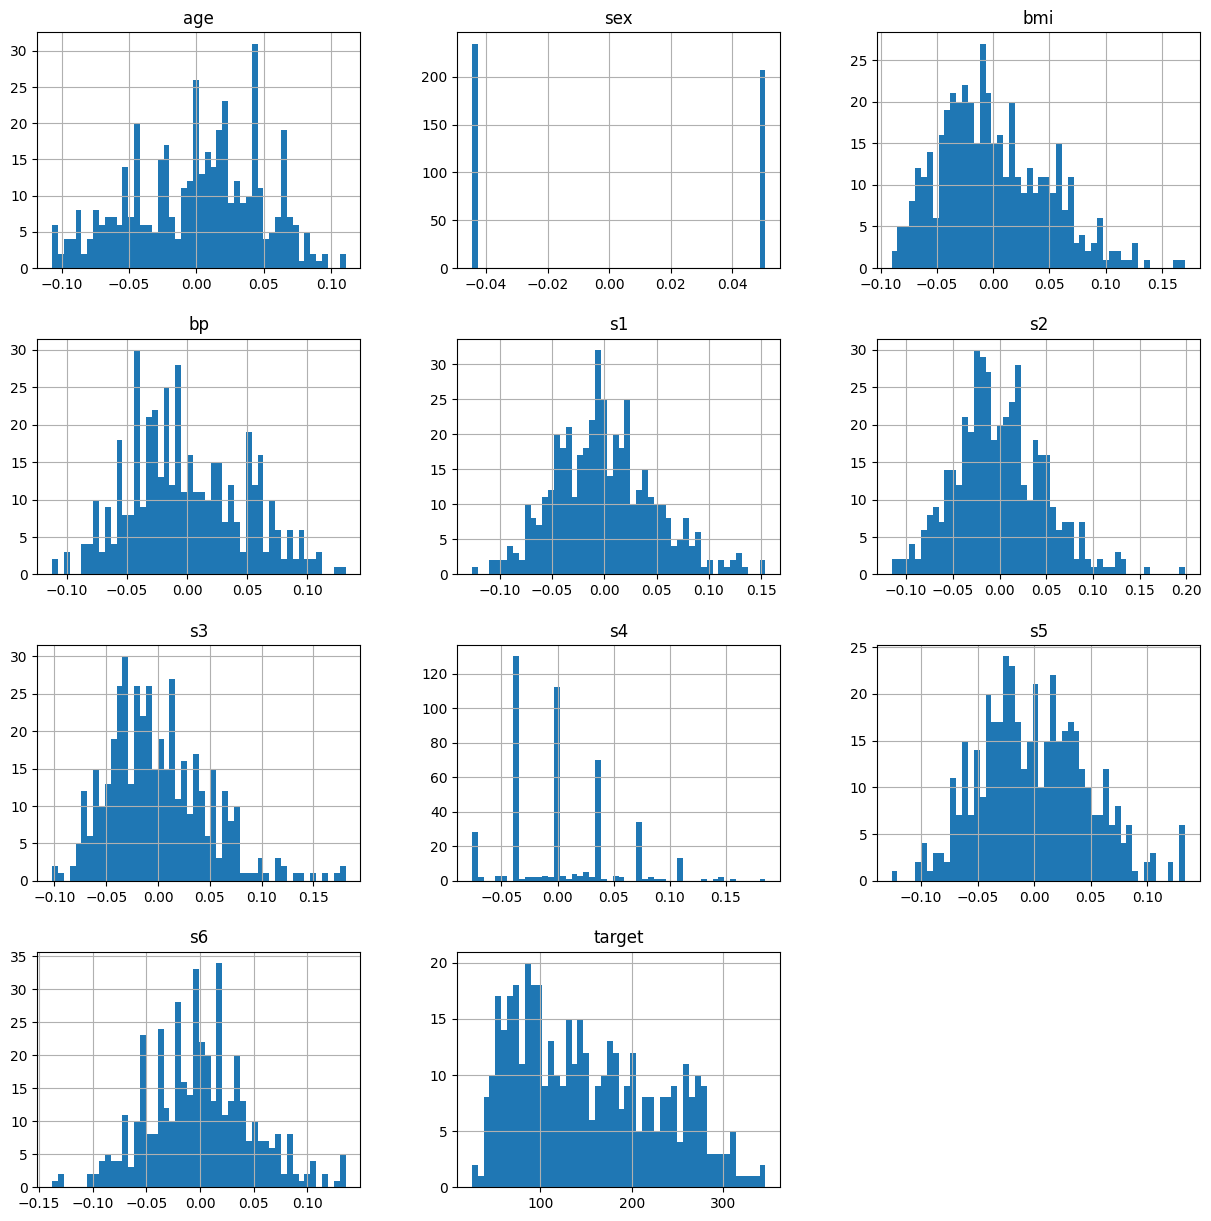

In [4]:
diabete.hist(bins=50, figsize=(15,15))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)




X_train_tensor[:,0].size(),y_train_tensor.size()

(torch.Size([353]), torch.Size([353, 1]))

# Training the model

In [6]:
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(10,1,
                                                requires_grad=True,
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
        
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return torch.matmul(x,self.weights)+ self.bias

## Raw model

In [7]:
torch.manual_seed(42)

linear_model = LinearRegressionModel()

linear_model.state_dict()

OrderedDict([('weights',
              tensor([[ 0.3367],
                      [ 0.1288],
                      [ 0.2345],
                      [ 0.2303],
                      [-1.1229],
                      [-0.1863],
                      [ 2.2082],
                      [-0.6380],
                      [ 0.4617],
                      [ 0.2674]])),
             ('bias', tensor([0.5349]))])

## Training loop

In [8]:
# loss function
loss_fn = nn.L1Loss()

# optimizer 
optimizer = torch.optim.SGD(params=linear_model.parameters(), lr=0.5)

y_pred = linear_model(X_train_tensor)
y_pred.size()

torch.Size([353, 1])

In [9]:
epochs = 100000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

torch.device("cuda:0")
for  epoch in range(epochs):

    # model in training mode
    linear_model.train()

    # forward pass
    y_pred = linear_model(X_train_tensor)

    # loss calculation
    loss = loss_fn(y_pred,y_train_tensor)

    # Zero grad of the optimizer 
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    # real_time testing
    linear_model.eval()

    with torch.inference_mode():
        test_pred = linear_model(X_test_tensor)

        test_loss = loss_fn(test_pred,y_test_tensor)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 153.20103454589844 | MAE Test Loss: 144.7427978515625 
Epoch: 10 | MAE Train Loss: 148.2009735107422 | MAE Test Loss: 139.74307250976562 
Epoch: 20 | MAE Train Loss: 143.20089721679688 | MAE Test Loss: 134.74334716796875 
Epoch: 30 | MAE Train Loss: 138.20083618164062 | MAE Test Loss: 129.7436065673828 
Epoch: 40 | MAE Train Loss: 133.20077514648438 | MAE Test Loss: 124.7438735961914 
Epoch: 50 | MAE Train Loss: 128.20689392089844 | MAE Test Loss: 119.74982452392578 
Epoch: 60 | MAE Train Loss: 123.26332092285156 | MAE Test Loss: 114.77842712402344 
Epoch: 70 | MAE Train Loss: 118.37033081054688 | MAE Test Loss: 109.83538818359375 
Epoch: 80 | MAE Train Loss: 113.52085876464844 | MAE Test Loss: 105.00871276855469 
Epoch: 90 | MAE Train Loss: 108.90849304199219 | MAE Test Loss: 100.40494537353516 
Epoch: 100 | MAE Train Loss: 104.56873321533203 | MAE Test Loss: 96.07785034179688 
Epoch: 110 | MAE Train Loss: 100.6949462890625 | MAE Test Loss: 92.21588897705078

## Evaluation

In [10]:
loss_fn2 = nn.MSELoss()

with torch.inference_mode():
    
    y_pred = linear_model(X_test_tensor)

    loss = loss_fn2(y_pred, y_test_tensor)

loss

tensor(2913.0291)